# Topic modelling for Dreamachine dataset : High Sensory (HS) condition


Author : Romy Beauté\
Date created : 13/05/2024\
Last modified : 04/11/2024\
Corresp : r.beaut@sussex.ac.uk

Selection of sentence transformer embedding models :
https://www.sbert.net/docs/pretrained_models.html

The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality



In [1]:
%%capture
!pip install bertopic accelerate bitsandbytes xformers adjustText
!pip install llama-cpp-python
!{sys.executable} -m pip install "scipy==1.9.0" "scikit-image==0.23.2"

import os
import nltk
import sys
import pandas as pd

current_dir = os.getcwd()  # should be in NOTEBOOKS
lyra_dir = os.path.abspath(os.path.join(current_dir, '..'))  # go up one level
print("Lyra directory:", lyra_dir)


# Change directory and update path
os.chdir(lyra_dir)
sys.path.insert(0, lyra_dir)
print("Current working directory:", os.getcwd())
print("Python path first entry:", sys.path[0])


from grid_search_colyra import *
from META_helpers_colyra import split_sentences,reduced_custom_stopwords


os.environ["TOKENIZERS_PARALLELISM"] = "True"
nltk.download('stopwords')


condition = "HS" 
sentences = True
reduced_GS = False
random_seed = 42
nr_topics = "auto" 



results_GS = pd.read_csv(f'/home/romy/lyra/RESULTS/grid_search_results_{condition}_seed42{"_sentences" if sentences else ""}{"_reduced" if reduced_GS else ""}.csv')

reports_path = os.path.join("DATA",f"{condition}_reflections_cleaned.csv")
df_reports = pd.read_csv(reports_path,sep="\t")['reflection_answer']


if sentences:
    df_reports = split_sentences(df_reports)


In [2]:
# # #only print the results that have between 10 and 25 number of topics
# results_GS = results_GS[results_GS['n_topics']<=25]
# results_GS = results_GS[results_GS['n_topics']>=10]
# results_GS = results_GS.sort_values(by='coherence_score',ascending=False)



results_GS.head(5)

n_components  n_neighbors  min_dist  min_cluster_size  min_samples  \
0            20           10      0.00                 5            5   
1            10           10      0.01                 5            5   
2            10           10      0.05                 5            5   
3            11           25      0.00                 5            5   
4             8           25      0.05                 5            5   

   top_n_words  coherence_score  cohenrece_score_umass  n_topics  
0            5         0.544046              -8.584155        20  
1            5         0.539967              -8.477483        19  
2            5         0.520395              -9.251760        20  
3            5         0.517514              -9.065032        19  
4            5         0.507955              -9.299547        16

In [3]:
chosen_params = results_GS.iloc[0]
chosen_params


n_components             20.000000
n_neighbors              10.000000
min_dist                  0.000000
min_cluster_size          5.000000
min_samples               5.000000
top_n_words               5.000000
coherence_score           0.544046
cohenrece_score_umass    -8.584155
n_topics                 20.000000
Name: 0, dtype: float64

In [4]:
sentence_transformer_model = "all-mpnet-base-v2" #"paraphrase-MiniLM-L6-v2"# #"BAAI/bge-small-en" "all-MiniLM-L6-v2'"
embedding_model = SentenceTransformer(sentence_transformer_model)
embeddings = embedding_model.encode(df_reports, show_progress_bar=True)
print(embedding_model)

vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=list(stopwords.words('english')),max_df=0.9,min_df=2)#+list(reduced_custom_stopwords)) #ngram_range=(1,2) : unigrams and bigrams

n_neighbors = int(chosen_params['n_neighbors'])
n_components = int(chosen_params['n_components'])
min_dist = float(chosen_params['min_dist'])
min_cluster_size = int(chosen_params['min_cluster_size'])
min_samples= int(chosen_params['min_samples']) if pd.notna(chosen_params['min_samples']) else None
top_n_words = int(chosen_params['top_n_words'])
nr_topics = "auto"



metric='cosine'

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)


In [5]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=n_neighbors, n_components=2, min_dist=min_dist, metric='cosine', random_state=random_seed).fit_transform(embeddings)

umap_model = UMAP(n_neighbors=n_neighbors,
                  n_components=n_components,
                  min_dist=min_dist,
                  metric=metric,
                  random_state=random_seed) # rdm seed for reportability

hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        gen_min_span_tree=True,
                        prediction_data=True)


In [6]:
model = BERTopic(
    umap_model=umap_model,
    low_memory=True,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    top_n_words=top_n_words,
    nr_topics= nr_topics,#default to None
    language='english',
    calculate_probabilities=True,
    verbose=True)

topics,_ = model.fit_transform(df_reports)

coherence_score,coherence_score_umass = calculate_coherence(model, df_reports) #sanitary check for coherence, that we obtain the same score as when running GS
print("Coherence Score:", coherence_score)

print(f"n = {len(np.unique(topics))} topics extracted")


#check how many documents identified as outliers
print(len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1]))

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Topics: [['experience', 'felt', 'relaxed', 'interesting', 'felt relaxed'], ['felt', 'space', 'like', 'flying', 'felt like'], ['peace', 'calm', 'joy', 'relaxation', 'sense'], ['colors', 'red', 'kaleidoscope', 'color', 'black'], ['vision', 'front', 'also', 'eyes', 'lights'], ['geometric', 'shapes', 'patterns', 'dots', 'geometric shapes'], ['music', 'sound', 'created', 'throughout', 'movement'], ['thought', 'mind', 'aware', 'thoughts', 'started'], ['would', 'could', 'wish', 'would like', 'try'], ['stars', 'saw', 'rapidly', 'saw stars', 'planets'], ['death', 'life', 'like', 'back', 'felt like'], ['journey', 'forward', 'complete', 'varying', 'towards something'], ['asleep', 'awake', 'put', 'whether', 'opened eyes'], ['drugs', 'potential', 'psychedelic', 'perhaps', 'emotional'], ['colors', 'many', 'within', 'colors shapes', 'eye'], ['memories', 'beautiful', 'back', 'remembered', 'rainbow'], ['patterns made', 'back', 'focused', 'patterns', 'made'], ['shapes', 'pink', 'moving', 'geometric', 's

In [7]:
#check sentences identified as outliers
# outliers = np.where(model.hdbscan_model.labels_==-1)[0]
# for i in outliers:
#     print(df_reports[i])


In [8]:
new_topics = model.reduce_outliers(df_reports, topics, strategy="embeddings",threshold=0.4)

# Check the impact
print(f"Original outliers: {len(model.hdbscan_model.labels_[model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

#print the sentences that are identified as outliers after reduction
outliers = np.where(np.array(new_topics)==-1)[0]
for i in outliers:
    print(df_reports[i])

# Verify coherence is maintained
model.topics_ = new_topics
coherence_score, coherence_score_umass = calculate_coherence(model, df_reports)
print(f"New coherence score: {coherence_score:.4f}")

Original outliers: 153
Remaining outliers after reduction: 35
A Flock of birds.
vast.
And then maybe backwards.
Then really fast.
immense.
it was possible to generate full images on demand - elephant made of upwards flowing oil rivulets
moving through a tunnel of branches
no green I did not see any green at all from start to finish
Sometimes verging on oppressive, but never scary.
phosphorescence on water.
a Welsh blanket.
I am beyond words...
Figures standing as though about to dance.
sometimes I would see clips eg like from a film interspersed every now and again
A vast desert of dunes.
A summer meadow.
what do I really understand?
brains, neurons, veins, elephants,
Saw x3 distinct images:
1.
Treasure Chests (x2 Opening, x1 Closed/Locked)
3.
there were lots of children playing with their parents, throwing balls in the air.
various characters who if focused on them would disappear.
at the end when everything calmed down I saw a person amongst the white in a hospital bed.
Felt like the

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Topics: [['experience', 'felt', 'relaxed', 'interesting', 'felt relaxed'], ['felt', 'space', 'like', 'flying', 'felt like'], ['peace', 'calm', 'joy', 'relaxation', 'sense'], ['colors', 'red', 'kaleidoscope', 'color', 'black'], ['vision', 'front', 'also', 'eyes', 'lights'], ['geometric', 'shapes', 'patterns', 'dots', 'geometric shapes'], ['music', 'sound', 'created', 'throughout', 'movement'], ['thought', 'mind', 'aware', 'thoughts', 'started'], ['would', 'could', 'wish', 'would like', 'try'], ['stars', 'saw', 'rapidly', 'saw stars', 'planets'], ['death', 'life', 'like', 'back', 'felt like'], ['journey', 'forward', 'complete', 'varying', 'towards something'], ['asleep', 'awake', 'put', 'whether', 'opened eyes'], ['drugs', 'potential', 'psychedelic', 'perhaps', 'emotional'], ['colors', 'many', 'within', 'colors shapes', 'eye'], ['memories', 'beautiful', 'back', 'remembered', 'rainbow'], ['patterns made', 'back', 'focused', 'patterns', 'made'], ['shapes', 'pink', 'moving', 'geometric', 's

In [9]:
topics = new_topics
_, probabilities = model.transform(df_reports)

print(f"Number of unique topics after update: {len(np.unique([t for t in topics if t != -1]))}")
print(f"Number of remaining outliers: {len([t for t in topics if t == -1])}")


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Number of unique topics after update: 19
Number of remaining outliers: 35


In [10]:
model.visualize_barchart(title=f'Topic Word Scores for {condition}',autoscale=True)

In [11]:
model.visualize_documents(df_reports,title=f'Documents and Topics for {condition}')

# LLAMA 3

In [12]:
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
# # !wget https://huggingface.co/TheBloke/zephyr-7B-alpha-GGUF/resolve/main/zephyr-7b-alpha.Q4_K_M.gguf

# # DataMapPlot
# !git clone https://github.com/TutteInstitute/datamapplot.git
# !pip install datamapplot/.

import datamapplot
import torch
torch.cuda.empty_cache()

# # Remove existing installations
# !pip uninstall -y cudf cuml cugraph cupy rmm

# Install RAPIDS packages in correct order
!pip install --upgrade rmm-cu12 --extra-index-url=https://pypi.nvidia.com/simple
!pip install --upgrade cudf-cu12 --extra-index-url=https://pypi.nvidia.com/simple
!pip install --upgrade cuml-cu12 --extra-index-url=https://pypi.nvidia.com/simple

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com/simple


In [13]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper

from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import re  # For regular expressions


#to speed up computation
import torch
torch.cuda.empty_cache()
from cuml.manifold import UMAP  # For UMAP dimensionality reduction
from cuml.cluster import HDBSCAN  # For clustering with HDBSCAN

#add periodic memory clearing (use if too slow to run)
def process_batch(batch):
    results = []
    for item in batch:
        results.append(process_item(item))
        if len(results) % 100 == 0:  # Clear memory every 100 items
            torch.cuda.empty_cache()
    return results


In [14]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename, cache_dir=path)

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"],verbose=False)

In [25]:



prompt = """Q:
Topic documents:
[DOCUMENTS]

Topic keywords: '[KEYWORDS]'

Create a specific, scientific label for this topic based on the above information. The label should:

1. Use proper spacing between words
2. Use Title Case (capitalize each significant word)
3. Not start or end with spaces
4. Focus on the core concept rather than methodology
5. Be a complete title (not cut off mid-word or mid-idea)
6. Be scientifically accurate
7. Do not use overly complex terminology

Only return the label itself, without any additional text or punctuation.
A:
"""


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt),
}


In [26]:
torch.cuda.empty_cache()

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
  nr_topics = nr_topics,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(df_reports,embeddings)

# Show topics
topic_model.get_topic_info()



100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


Topic  Count                                 Name  \
0      -1    153                     -1_the_and_in_of   
1       0    110             0_experience_felt_it_was   
2       1     83               1_felt_was_the_through   
3       2     62               2_peace_calm_sense_joy   
4       3     49                  3_colors_and_red_of   
5       4     35                   4_my_vision_the_of   
6       5     30   5_geometric_shapes_patterns_spiral   
7       6     21                6_music_sound_the_and   
8       7     18                 7_my_thought_mind_as   
9       8     18                 8_do_would_how_could   
10      9     16          9_stars_saw_rapidly_planets   
11     10     13               10_death_life_you_like   
12     11     12  11_journey_forward_oblivion_unknown   
13     12     11         12_dreaming_asleep_awake_put   
14     13     11             13_drugs_lsd_dmt_closest   
15     14     10               14_colors_many_were_of   
16     15      9        15_memories_my_beautiful_back   
17     16      7             16_focus_back_focused_on   
18     17      7              17_shapes_moving_and_if   
19     18      7   18_dream_machine_dreamachine_still   

                                       Representation  \
0       [the, and, in, of, to, saw, my, at, it, with]   
1   [experience, felt, it, was, and, very, relaxed...   
2   [felt, was, the, through, space, like, of, in,...   
3   [peace, calm, sense, joy, relaxation, and, pea...   
4   [colors, and, red, of, kaleidoscope, color, sh...   
5   [my, vision, the, of, to, front, also, eyes, w...   
6   [geometric, shapes, patterns, spiral, spiralin...   
7   [music, sound, the, and, seemed, created, how,...   
8   [my, thought, mind, as, thoughts, aware, the, ...   
9   [do, would, how, could, it, again, this, to, s...   
10  [stars, saw, rapidly, planets, large, like, sh...   
11  [death, life, you, like, rebirth, die, it, so,...   
12  [journey, forward, oblivion, unknown, expansio...   
13  [dreaming, asleep, awake, put, was, flashes, w...   
14  [drugs, lsd, dmt, closest, acid, on, psychedel...   
15  [colors, many, were, of, within, bees, some, p...   
16  [memories, my, beautiful, back, them, glitteri...   
17  [focus, back, focused, on, patterns, made, to,...   
18  [shapes, moving, and, if, pink, was, through, ...   
19  [dream, machine, dreamachine, still, quite, in...   

                                              KeyBERT  \
0   [felt, visuals, kaleidoscope, sensory, kaleido...   
1   [felt, fun, experience, euphoric, euphoria, ov...   
2   [felt, flying, feeling, universe, space, exper...   
3   [calm, peace, peaceful, tranquility, peacefuln...   
4   [colors, multicolored, kaleidoscope, kaleidosc...   
5   [vision, eyes, seeing, felt, eye, focused, lig...   
6   [patterns, circles, spiraling, shapes, geometr...   
7   [music, songs, sound, rhythms, sounds, immersi...   
8   [subconscious, imagery, thinking, mind, concen...   
9   [meditative, breathing, massage, exercise, min...   
10  [stars, kaleidoscope, light, planets, eruption...   
11  [reincarnating, souls, death, rebirth, soul, l...   
12  [journey, progress, awareness, towards, motion...   
13  [wakefulness, dreaming, dreams, dreamingly, dr...   
14  [psychedelics, hallucinogens, psychedelic, lsd...   
15  [hallucinations, visuals, colors, perceptions,...   
16  [memories, childhood, memory, felt, remembered...   
17  [patterns, focusing, distracted, pattern, focu...   
18  [vortexes, kaleidoscope, pulsating, vortex, fe...   
19  [dreamachine, dream, stillness, magical, bliss...   

                                                  LLM  \
0   [Psychological Response to Visual and Auditory...   
1   [Mystical Sensory Liberation Experience\n\nNot...   
2   [Mystical Experience of Cosmic Oneness\n```\n\...   
3   [Serene State Induction Experience\n----------...   
4   [Color Pattern Dynamics and Morphology\n------...   
5   [Pulsatile Ophthalmic Visual Phenomena\n\n\nTh...   
6   [Geomet

In [27]:
# outlier reduction using embeddingd
new_topics = topic_model.reduce_outliers(df_reports, topics,strategy='embeddings',threshold=0.4)

# Check the impact
print(f"Original outliers: {len(topic_model.hdbscan_model.labels_[topic_model.hdbscan_model.labels_==-1])}")
print(f"Remaining outliers after reduction: {len([t for t in new_topics if t == -1])}")

topic_model.topics_ = new_topics

topics = new_topics


Original outliers: 153
Remaining outliers after reduction: 35


In [28]:



llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]

llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics] 

filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)



#set topic labels for visu
unique_topics = sorted(set(topics))
topic_labels = {topic_id: llm_labels[i] for i, topic_id in enumerate(unique_topics) if topic_id != -1}
topic_model.set_topic_labels(topic_labels)

topic_labels

{0: 'Mystical Sensory Liberation Experience',
 1: 'Mystical Experience of Cosmic Oneness',
 2: 'Serene State Induction Experience',
 3: 'Color Pattern Dynamics and Morphology',
 4: 'Pulsatile Ophthalmic Visual Phenomena',
 5: 'Geometric Pattern Dynamics Spiraling Into Circularity',
 6: 'Multidimensional Sonic Experience Creation',
 7: 'Self Awareness in Visual Perception and Cognitive Processes During Meditation',
 8: 'Meditative Breathing Exercise for Relaxation and Rejuvenation',
 9: 'Cosmic Phenomena Observation Report',
 10: 'Death Rebirth Experience and Perception',
 11: 'The Expansion Toward Motivation and Progress in Journey Forward Oblivion',
 12: 'Dream State Border Phenomenon',
 13: 'Psychedelic Drug Experience and Potential Exploration',
 14: 'Multisensory Color Pattern Perceptions and Ancestral Visions',
 15: 'Revisiting Vivid Autobiographical Memories of Joyful Experiences with Family',
 16: 'Captivating Patterns and Focus Challenges in Sensory Experience',
 17: 'Geometric

In [29]:
topic_model.visualize_documents(df_reports, title=f"Documents and Topics for {condition} (Llama 3)",
hide_annotations=True, hide_document_hover=False, custom_labels=True)

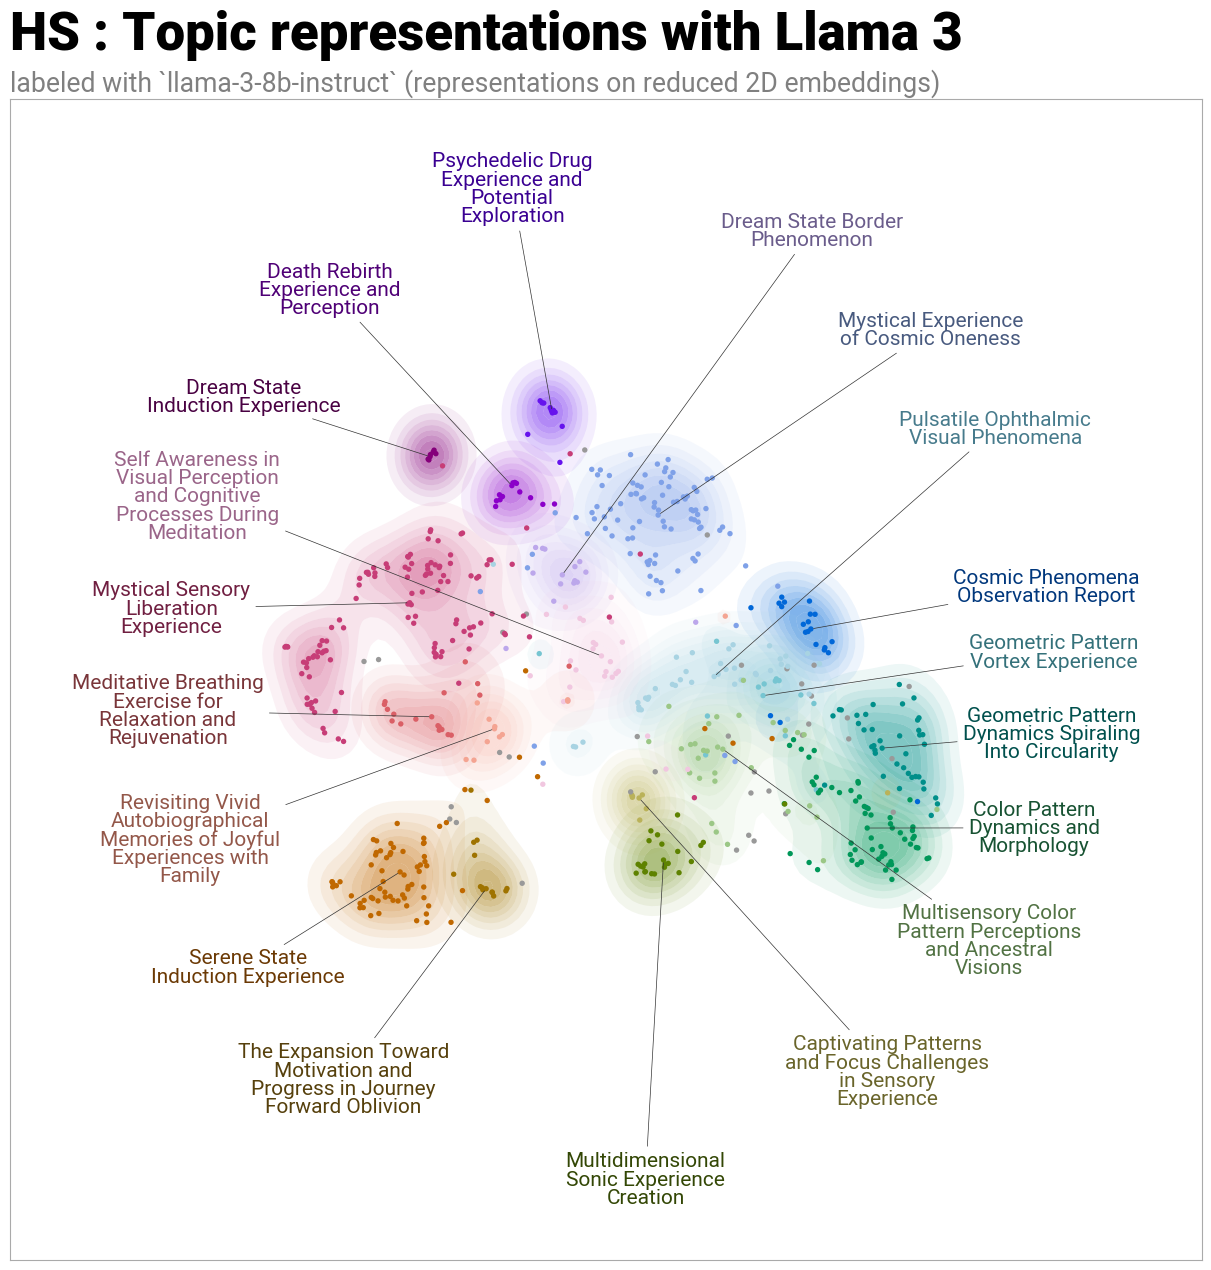

In [31]:
# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title=f"{condition} : Topic representations with Llama 3",
   sub_title="labeled with `llama-3-8b-instruct` (representations on reduced 2D embeddings)",
   label_wrap_width=20,
   use_medoids=True
);

In [32]:

hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=True, color_threshold=.9)
hierarchy_vis

In [33]:
# Create a DataFrame with topic statistics and content
topic_analysis = pd.DataFrame({
    'Topic_Label': all_labels,
    'Topic_Content': df_reports,
    'Topic_Number': topics
}).reset_index()

# Get topic counts and contents
topic_summary = (
    topic_analysis
    .groupby(['Topic_Label', 'Topic_Number'])
    .agg({
        'index': 'count',  # Count of sentences
        'Topic_Content': lambda x: list(x)  # List of all sentences
    })
    .rename(columns={'index': 'Sentence_Count'})
    .sort_values('Sentence_Count', ascending=False)
    .reset_index()
)


# Save to CSV if needed
topic_summary.to_csv(f'topic_analysis_{condition}.csv', index=False)

# Display DataFrame
print("\nSummary DataFrame:")
print(topic_summary[['Topic_Label', 'Topic_Number', 'Sentence_Count']])


Summary DataFrame:
                                          Topic_Label  Topic_Number  \
0              Mystical Sensory Liberation Experience             0   
1               Mystical Experience of Cosmic Oneness             1   
2                   Serene State Induction Experience             2   
3               Color Pattern Dynamics and Morphology             3   
4   Geometric Pattern Dynamics Spiraling Into Circ...             5   
5               Pulsatile Ophthalmic Visual Phenomena             4   
6                                          Unlabelled            -1   
7   Multisensory Color Pattern Perceptions and Anc...            14   
8   Self Awareness in Visual Perception and Cognit...             7   
9          Multidimensional Sonic Experience Creation             6   
10                Cosmic Phenomena Observation Report             9   
11  Meditative Breathing Exercise for Relaxation a...             8   
12                      Dream State Border Phenomenon    

In [34]:
# After your existing topic modeling code
hierarchical_topics = topic_model.hierarchical_topics(
    docs=df_reports,
    linkage_function=None  # Default is ward
)

# Visualize hierarchy
hierarchical_viz = topic_model.visualize_hierarchy(
    hierarchical_topics=hierarchical_topics,
    custom_labels=True  # Use your LLaMA labels
)

# Get text representation of hierarchy
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

100%|██████████| 18/18 [00:00<00:00, 682.60it/s]

.
├─and_of_colors_saw_shapes
│    ├─■──stars_saw_rapidly_planets_large ── Topic: 9
│    └─and_colors_of_shapes_saw
│         ├─■──shapes_moving_and_if_pink ── Topic: 17
│         └─colors_and_of_shapes_patterns
│              ├─■──geometric_shapes_patterns_spiral_spiraling ── Topic: 5
│              └─colors_and_of_patterns_color
│                   ├─■──colors_and_red_of_kaleidoscope ── Topic: 3
│                   └─■──colors_many_were_of_within ── Topic: 14
└─the_and_was_it_to
     ├─the_was_it_and_felt
     │    ├─music_the_and_sound_it
     │    │    ├─■──music_sound_the_and_seemed ── Topic: 6
     │    │    └─■──focus_back_focused_on_patterns ── Topic: 16
     │    └─was_the_felt_it_to
     │         ├─was_felt_the_it_my
     │         │    ├─it_death_would_do_this
     │         │    │    ├─■──death_life_you_like_rebirth ── Topic: 10
     │         │    │    └─■──do_would_how_could_it ── Topic: 8
     │         │    └─was_felt_the_my_and
     │         │         ├─felt_was_the_o